# A production network agent-based model

## Model01

Giulio Bottazzi, Daniele Giachini, Eleonora Priori.

A first version of a production network agent-based model with decreasing returns to scale.

Agents in the model are thought to be instantiated with a Social Accounting Matrix providing them an empirical data initialisation.

Comments welcome. Please do not quote.

Last update: May 19, 2023.


In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import random as r
import commonVar as cmv
import numpy as np
import pandas as pd
#import sys

from tools import *
from plot import *
from metaActions1 import *
from generateSeeds import *
from initMatricesAndSeries import *

### Model's parameters

In [3]:
"""
cmv.firmsNum=2
cmv.householdNum=1
cmv.nOfCycles=20
cmv.replications=2
cmv.betaVector=np.array([0.5,0.5])
cmv.matrixA=np.matrix([[0.1,0.3],[0.4, 0.05]])
cmv.matrixE=np.matrix([[0.1],[0.05]])
cmv.E=1
cmv.a1=[0.2,0.15]

"""
cmv.firmsNum=3
cmv.householdNum=1
cmv.nOfCycles=100
cmv.replications=100

cmv.betaVector=np.array([0.5,0.25,0.25])
cmv.matrixA=np.matrix([[0.1,0.3, 0],[0, 0.05, 0.4],[0.3, 0, 0.2]])
cmv.matrixE=np.matrix([[0.1],[0.05],[0.2]])
cmv.E=1
cmv.a1=[0.2,0.15,0.3]

#remember that also cmv.zetaVector is a parameter to be set (in model clearing functions because it changes at each cycle)

### Agents: the representative household and their functions

After stating their initial parameters the representative household defines their consumption behavior.

They selects their consumption over each good and identifies the utlity they achieves from the consumption.

In [4]:
class Household():
    def __init__(self, num,r,seed):
        self.num=num
        self.r=r.Random()
        self.r.seed(seed)
        
        self.myBeta=[] # values of the beta vector summing to 1
        self.consumption=[]
        self.utility=0
        
    def stateHouseholdParameters(self):
        if cmv.cycle==0:
            self.myBeta=cmv.betaVector
            #print(self.myBeta)
    
    
    def consume(self):
        self.consumption=[]
        for aFirm in cmv.firmsList:
            self.consumption.append(self.myBeta[aFirm.num-1]/aFirm.price)  
        self.consumption=np.ravel(np.array([self.consumption]))
        self.consumption=self.consumption.tolist()
        #print(self.consumption)
        
        for i in range(len(self.consumption)):
            self.utility=np.prod((self.consumption[i]/self.myBeta[i])**self.myBeta[i])
        #print(self.utility)
    

### Agents: the firms and their functions

After stating their initial parameters, the firms perform two main functions.


They have to define the "equilibrium" price for the goods they produce and the corresponding quantity of output they produce.

In [5]:
class Firm():
    def __init__(self, num,r,seed):
        self.num=num
        self.r=r.Random()
        self.r.seed(seed)
        self.eta=0
        self.productivityOfInputs=[] # values of the ith row of A matrix
        self.productivityOfFactors=[] # values of the ith row of E matrix
        self.productivityOfLabor=0
        self.logValueOfProduction=0
        self.valueOfProduction=0     
        self.logQuantityOfOutput=0
        self.quantityOfOutput=0        
        self.logPrice=0
        self.price=0
        
    def stateFirmsParameters(self):
        if cmv.cycle==0:
            self.productivityOfInputs=cmv.matrixA[self.num-1]
            self.productivityOfFactors=cmv.matrixE[self.num-1]
            self.productivityOfLabor=cmv.a1[self.num-1]
            self.eta=cmv.etaVector[self.num-1]            

            self.logValueOfProduction=self.eta*np.log(cmv.betaGamma[0,self.num-1]) 
            
        
    def identifyEquilibriumPrice(self):
        self.logPrice=cmv.gammaMatrix.dot(cmv.partialPricesVector)[self.num-1]
        self.price=np.exp(self.logPrice)
        self.price=self.price[0,0]
        #print("cycle ", cmv.cycle, "firm ", self.num,"price ", self.price)
        
    def identifyEquilibriumOutput(self):
        #print(self.num, cmv.partialOutputVector[0,self.num-1], self.eta)
        self.logQuantityOfOutput=cmv.partialOutputVector[0,self.num-1]/self.eta
        self.quantityOfOutput=np.exp(self.logQuantityOfOutput)
        #print("cycle ", cmv.cycle, "firm ", self.num, "quantity ", self.quantityOfOutput)    

### Model's clearing functions

The model performs some technical clearing functions.

These provide a centralized computation of some variables helping the agents to manage the individual functions they perform.

In [6]:
def stateModelParameters():
    if cmv.cycle==0:
        rowSumA=[]
        rowSumE=[]
        eta=[]
        for i in range(cmv.firmsNum):
            rowSumA.append(np.sum(cmv.matrixA[i]))
            rowSumE.append(np.sum(cmv.matrixE[i]))  
        eta.append(np.ones(cmv.firmsNum)- rowSumA[i] - rowSumE[i])
        cmv.etaVector=eta[0]
        
        cmv.gammaMatrix=np.linalg.inv(np.identity(cmv.firmsNum)-cmv.matrixA)
        cmv.gammaHat=(np.identity(cmv.firmsNum)*(1-cmv.etaVector)-cmv.matrixA)
        
        cmv.betaGamma=cmv.betaVector.dot(cmv.gammaMatrix)
        cmv.betaGammaE=cmv.betaGamma.dot(cmv.matrixE)
        
        cmv.logPriceOfFactors=np.log(cmv.betaGammaE/cmv.E) 
        cmv.priceOfFactors=np.exp(cmv.logPriceOfFactors)[0,0]
        #print(cmv.priceOfFactors)


def redefineTFP():
    #cmv.zetaVector=[2,4,6]
    cmv.zetaVector=[r.uniform(1,5),r.uniform(1,5),r.uniform(1,5)] # here because it is computed as new at each cycle
    cmv.muHatVector=[]
    for i in range(len(cmv.zetaVector)):
        cmv.muHatVector.append(-np.log(1/cmv.zetaVector[i]))
    #print(cmv.zetaVector, cmv.muHatVector)        


def computePartialPricesMatrix():
    logValuesOfProductionVector=[]
    if cmv.cycle==0:
        for aFirm in cmv.firmsList:
            logValuesOfProductionVector.append(aFirm.logValueOfProduction)
        logValuesOfProductionVector=np.array(logValuesOfProductionVector)
    
    cmv.partialPricesVector= logValuesOfProductionVector+cmv.muHatVector+\
                        ((cmv.matrixE.dot(cmv.priceOfFactors)).transpose())
    cmv.partialPricesVector=cmv.partialPricesVector.transpose()
        
def computePartialOutputMatrix():
    logPricesVector=[]
    for aFirm in cmv.firmsList:
        logPricesVector.append(aFirm.logPrice[0,0])
    logPricesVector=np.array(logPricesVector)
    
    cmv.partialOutputVector=cmv.muHatVector+(np.array(cmv.gammaHat.dot(logPricesVector).transpose()).transpose())\
                           -np.array(cmv.matrixE.dot(cmv.logPriceOfFactors)).transpose()
    #print(cmv.partialOutputVector)
    

### Model's setup

Here we define the model setup initializing the creation of the agents and of the data matrices of the model.

To keep the code as simple as possible, the functions initializing the matrices and the time series of the model are kept in a separate file and only re-called in this section.

In [7]:
def setup(r,seed):
    
    seedManager(r,seed,'setup',setup)
    
  
    cmv.householdList=[]
    for n in range(cmv.householdNum):
        aHousehold=Household(n+1,r,cmv.householdSeedList[n])
        cmv.householdList.append(aHousehold)
    #print(cmv.householdList)
    
    cmv.firmsList=[]
    for n in range(cmv.firmsNum):
        aFirm=Firm(n+1,r,cmv.firmSeedList[n])
        cmv.firmsList.append(aFirm)
    #print(cmv.firmsList)
    
    initMatrices()
    initSeries()

### Model's scheduling

Here we define the schedule of the model, selecting the order in which different classes of agents (or the model itself) have to perform their functions to achieve the output scenario of the simulation.

The metaActions file deals with the collective functions of single agents such that all the agents of each a class perform the same action at the same time. The model-clearing functions do not need to pass through the metaActions file.


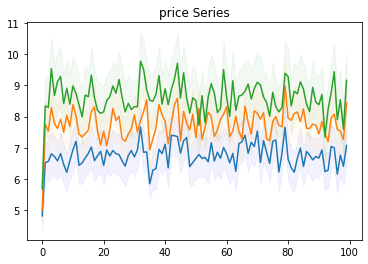

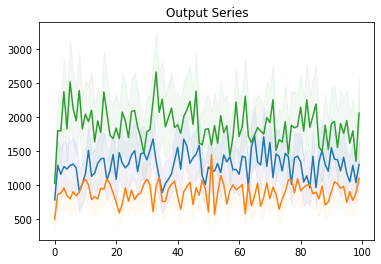

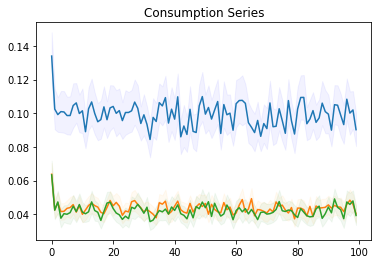

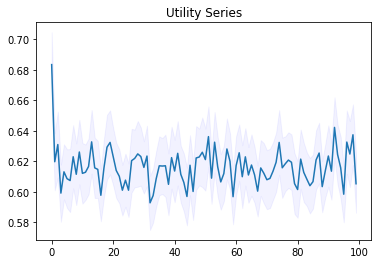

In [8]:
initMontecarlo()

for i in range(cmv.replications):     
    r.seed(r.uniform(1000,9000))
    generateSeeds()
    setup(r,cmv.functionSeedList[0])

    cmv.actionList=["stateModelParameters()","stateHouseholdParametersAll()","stateFirmsParametersAll()",\
                    "redefineTFP()", "computePartialPricesMatrix()", "identifyEquilibriumPriceAll()", \
                    "computePartialOutputMatrix()","identifyEquilibriumOutputAll()", "consumeAll()", "computeSeries()"]

    for cmv.cycle in range(cmv.nOfCycles):
        #print("cycle:", cmv.cycle)
        for anAction in cmv.actionList:            
                exec(anAction)
    makeSeries()
makePlotsMontecarlo()